In [1]:
from lfads_tf2.utils import load_data, load_posterior_averages
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import k3d
import numpy as np
from src.models import SSA
import seaborn as sns

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')

In [3]:
with open('../params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)['lfads_prep']

td_cst = trial_data.groupby('task').get_group('CST')
td_cst = pyaldata.combine_time_bins(td_cst,int(params['bin_size']/td_cst['bin_size'].values[0]))

trial_ids = load_data(
    '../data/pre-lfads/', 
    prefix='Earl_20190716_CST', 
    signal='trial_id',
    merge_tv=True)[0].astype(int)

post_data = load_posterior_averages('../results/lfads/Earl_20190716_CST', merge_tv=True)
td_cst = src.lfads_helpers.add_lfads_rates(td_cst, post_data.rates/params['bin_size'], chopped_trial_ids=trial_ids, overlap=params['overlap'], new_sig_name='lfads_rates')
td_cst = src.lfads_helpers.add_lfads_rates(td_cst, post_data.gen_inputs, chopped_trial_ids=trial_ids, overlap=params['overlap'], new_sig_name='lfads_gen_inputs')

td_cst = src.data.trim_nans(td_cst,ref_signals=['rel_hand_pos','lfads_rates'])
# td_cst = src.data.fill_kinematic_signals(td_cst)

td_cst['M1_rates'] = [
    pyaldata.smooth_data(
        spikes/bin_size,
        dt=bin_size,
        std=0.05,
        backend='convolve',
    ) for spikes,bin_size in zip(td_cst['M1_spikes'],td_cst['bin_size'])
]
M1_pca_model = PCA()
td_cst = pyaldata.dim_reduce(td_cst,M1_pca_model,'M1_rates','M1_pca')

lfads_pca_model = PCA()
td_cst = pyaldata.dim_reduce(td_cst,lfads_pca_model,'lfads_rates','lfads_pca')

start_time = -1.0
end_time = 5.0
td_cst = pyaldata.restrict_to_interval(
    td_cst,
    start_point_name='idx_goCueTime',
    rel_start=int(start_time/td_cst.loc[td_cst.index[0],'bin_size']),
    rel_end=int(end_time/td_cst.loc[td_cst.index[0],'bin_size']),
    reset_index=False
)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 67 182 219 220 255 312 339 522]


In [16]:
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='Neural Traces')
# plot traces
for neural_trace in td_cst['M1_pca'].sample(n=25):
    trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,color=0)

# trace_plot+=k3d.line(td_cst['M1_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=0)

trace_plot.display()


Output()

In [17]:
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='Neural Traces')
# plot traces
for neural_trace in td_cst['lfads_pca'].sample(n=25):
    trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,color=0)

# trace_plot+=k3d.line(td_cst['lfads_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=0)

trace_plot.display()



Output()

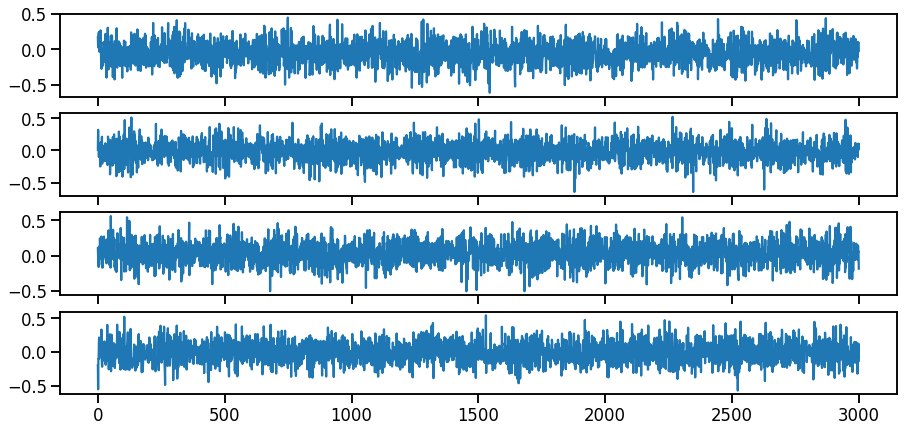

In [18]:
fig,axs = plt.subplots(4,1,figsize=(15,7),sharex=True)

for plotnum,ax in enumerate(axs):
    ax.plot(td_cst.iloc[134]['lfads_gen_inputs'][:,plotnum])

In [7]:
num_dims = 10
M1_ssa_model = SSA(R=num_dims,n_epochs=3000,lr=0.01)
td_cst = pyaldata.dim_reduce(td_cst,M1_ssa_model,'M1_rates','M1_ssa')

lfads_ssa_model = SSA(R=num_dims,n_epochs=3000,lr=0.01)
td_cst = pyaldata.dim_reduce(td_cst,lfads_ssa_model,'lfads_rates','lfads_ssa')


Using lam_sparse=  2.7182132213126087
Using device cuda:0


100%|██████████| 3000/3000 [01:09<00:00, 43.38it/s]


Using lam_sparse=  0.27041640617717316
Using device cuda:0


100%|██████████| 3000/3000 [01:08<00:00, 44.03it/s]


Text(0.5, 0, 'Training Epoch')

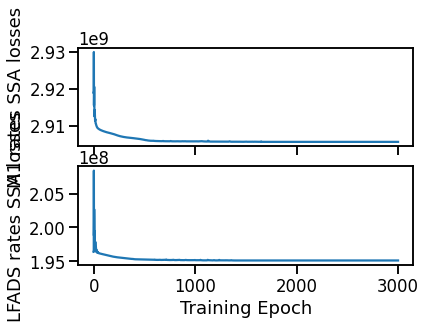

In [8]:
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(M1_ssa_model.losses)
axs[0].set_ylabel('M1 rates SSA losses')
axs[1].plot(lfads_ssa_model.losses)
axs[1].set_ylabel('LFADS rates SSA losses')
axs[1].set_xlabel('Training Epoch')


Text(0.5, 1.0, 'PCA LowD Projections')

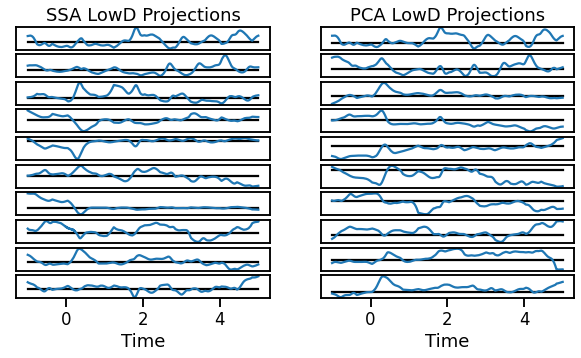

In [20]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
trial = td_cst.iloc[5,:]

plt.figure(figsize=(10,5))
for i in range(num_dims):
    
    # Plot SSA results
    plt.subplot(num_dims,2,2*i+1)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['lfads_ssa'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(num_dims,2,2*i+2)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['lfads_pca'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

#Titles
plt.subplot(num_dims,2,1)
plt.title('SSA LowD Projections')

plt.subplot(num_dims,2,2)
plt.title('PCA LowD Projections')


In [13]:
from ipywidgets import interact
# plot out SSA projections and hand/cursor movement
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
# trial = td_cst.sample(n=1).squeeze()

@interact(trial_id = list(td_cst['trial_id']))
def plot_trial_ssa(trial_id):
    trial = td_cst.loc[td_cst['trial_id']==trial_id,:].squeeze()
    fig,axs = plt.subplots(num_dims+1,1,figsize=(5,10),sharex=True)
    for i,ax in enumerate(axs):
        # ax.clear() 
        if i<num_dims:
            # Plot SSA results
            ax.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
            ax.plot(trial['trialtime'],trial['lfads_ssa'][:,i])
            ax.set_yticks([])
            ax.set_ylabel('{}'.format(i))
        else:
            ax.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
            ax.plot(trial['trialtime'],trial['rel_hand_pos'][:,0],'r')
            ax.plot(trial['trialtime'],trial['rel_cursor_pos'][:,0],'b')
            ax.set_yticks([])
            ax.set_xlabel('Time')

        ax.plot([0,0],ax.get_ylim(),color='k',linestyle='--')

    sns.despine(fig=fig,left=True,bottom=True,trim=True)
    
#     plt.ylim([-1.1, 1.1])

#Titles
# plt.subplot(num_dims,2,1)
# plt.title('SSA LowD Projections')
# 
# plt.subplot(num_dims,2,2)
# plt.title('PCA LowD Projections')


interactive(children=(Dropdown(description='trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 20, 2…

In [29]:
trial['lfads_ssa'][:,0]

array([-15.51578  , -15.417253 , -15.3073015, ...,  -4.9326324,
        -4.892358 ,  -4.866542 ], dtype=float32)

In [22]:
# import pickle
# with open('../results/ssa/Earl_20190716_CST_lfads_ssa.pkl','wb') as f:
#     pickle.dump(lfads_ssa_model.model,f)
# with open('../results/ssa/Earl_20190716_CST_M1_ssa.pkl','wb') as f:
#     pickle.dump(M1_ssa_model.model,f)

import torch
torch.save(lfads_ssa_model.model,'../results/ssa/Earl_20190716_CST_lfads_ssa_model.pt')

# loaded_lfads_ssa_model = SSA(R=num_dims,n_epochs=3000,lr=0.01)
# loaded_lfads_ssa_model.model = torch.load('../results/ssa/Earl_20190716_CST_lfads_ssa_model.pt')
# loaded_lfads_ssa_model.model.eval()

RuntimeError: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training